In [ ]:
from imutils import contours
from skimage import measure
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

# load the image, convert it to grayscale, and blur it
image = cv2.imread('/content/comp algo-2.PNG')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (11, 11), 0)
thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=4)

labels = measure.label(thresh, neighbors=8, background=0)
mask = np.zeros(thresh.shape, dtype="uint8")
for label in np.unique(labels):
	if label == 0:
		continue
	labelMask = np.zeros(thresh.shape, dtype="uint8")
	labelMask[labels == label] = 255
	numPixels = cv2.countNonZero(labelMask)
	if numPixels > 300:
		mask = cv2.add(mask, labelMask)
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts)[0]
for (i, c) in enumerate(cnts):
	(x, y, w, h) = cv2.boundingRect(c)
	((cX, cY), radius) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(cX), int(cY)), int(radius),
		(0, 0, 255), 3)
	cv2.putText(image, "#{}".format(i + 1), (x, y - 15),
		cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
plt.imshow(image)
cv2.waitKey(0)

error: ignored

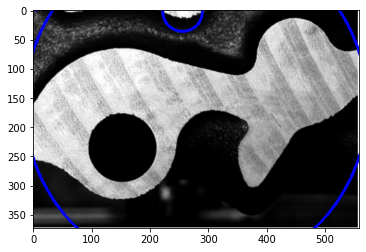

In [ ]:
#cv2.getStructuringElement
lookUpTable = np.empty((1,256), np.uint8)
gamma = 3
for i in range(256):
  lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
res = cv2.LUT(image, lookUpTable)
plt.imshow(res)

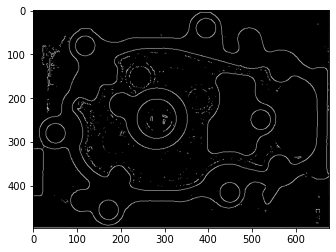

In [ ]:
imm = cv2.imread('/content/comp algo-11.PNG',0)
edges = cv2.Canny(imm,300,300)
plt.imshow(edges,cmap='gray')

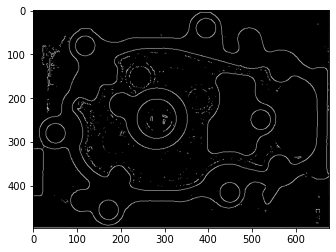

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
opening = cv2.morphologyEx(edges, cv2.MORPH_OPEN, kernel)
plt.imshow(opening,cmap='gray')

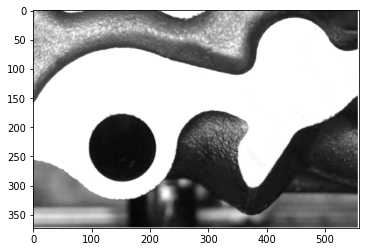

In [ ]:
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity
from skimage.io import imread, imsave

img = imread('/content/comp algo-2.PNG')

yen_threshold = threshold_yen(img)
bright = rescale_intensity(img, (0, yen_threshold), (0, 255))

plt.imshow(bright)

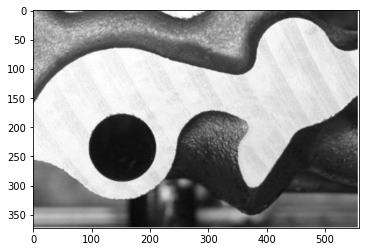

In [ ]:
def adjust_gamma(image, gamma=1.2):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)
l=adjust_gamma(img)
plt.imshow(l)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


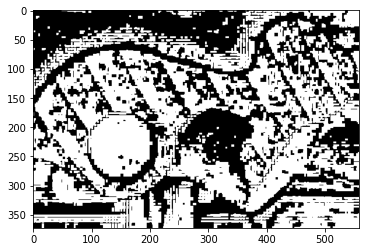

In [ ]:
BLOCK_SIZE = 5
DELTA = 5
def preprocess(image):
    image = cv2.medianBlur(image, 3)
    return 255 - image

def postprocess(image):
    kernel = np.ones((3,3), np.uint8)
    image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return image

#helper function that generates box coordinates
def get_block_index(image_shape, yx, block_size): 
    y = np.arange(max(0, yx[0]-block_size), min(image_shape[0], yx[0]+block_size))
    x = np.arange(max(0, yx[1]-block_size), min(image_shape[1], yx[1]+block_size))
    return np.meshgrid(y, x)

def adaptive_median_threshold(img_in):
    med = np.median(img_in)
    img_out = np.zeros_like(img_in)
    img_out[img_in - med < DELTA] = 255
    kernel = np.ones((3,3),np.uint8)
    img_out = 255 - cv2.dilate(255 - img_out,kernel,iterations = 2)
    return img_out

def block_image_process(image, block_size):
    out_image = np.zeros_like(image)
    for row in range(0, image.shape[0], block_size):
        for col in range(0, image.shape[1], block_size):
            idx = (row, col)
            block_idx = get_block_index(image.shape, idx, block_size)
            out_image[block_idx] = adaptive_median_threshold(image[block_idx])
    return out_image

def process_image(img):
    image_in = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image_in = preprocess(image_in)
    image_out = block_image_process(image_in, BLOCK_SIZE)
    image_out = postprocess(image_out)
    return image_out
k=process_image(l)
plt.imshow(k,cmap='gray')

In [ ]:

# This is the function used for composing
def sigmoid(x, orig, rad):
    k = np.exp((x - orig) * 5 / rad)
    return k / (k + 1.)

def combine_block(img_in, mask):
    img_out = np.zeros_like(img_in)
    img_out[mask == 255] = 255
    fimg_in = img_in.astype(np.float32)

    idx = np.where(mask == 0)
    if idx[0].shape[0] == 0:
        img_out[idx] = img_in[idx]
        return img_out
    lo = fimg_in[idx].min()
    hi = fimg_in[idx].max()
    v = fimg_in[idx] - lo
    r = hi - lo
    img_in_idx = img_in[idx]
    ret3,th3 = cv2.threshold(img_in[idx],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    bound_value = np.min(img_in_idx[th3[:, 0] == 255])
    bound_value = (bound_value - lo) / (r + 1e-5)
    f = (v / (r + 1e-5))
    f = sigmoid(f, bound_value + 0.05, 0.2)

    img_out[idx] = (255. * f).astype(np.uint8)
    return img_out

def combine_block_image_process(image, mask, block_size):
    out_image = np.zeros_like(image)
    for row in range(0, image.shape[0], block_size):
        for col in range(0, image.shape[1], block_size):
            idx = (row, col)
            block_idx = get_block_index(image.shape, idx, block_size)
            out_image[block_idx] = combine_block(
                image[block_idx], mask[block_idx])
    return out_image

def combine_postprocess(image):
    return image

def combine_process(img, mask):
    image_in = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image_out = combine_block_image_process(image_in, mask, 20)
    image_out = combine_postprocess(image_out)
    return image_out
combine_process(img,)

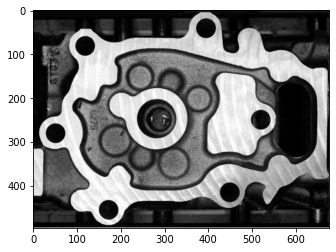

In [ ]:
image1 = cv2.imread('/content/comp algo-11.PNG')
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

cnts = cv2.findContours(gray1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    cv2.drawContours(gray,[c], 0, (255,255,255), -1)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
opening = cv2.morphologyEx(gray1, cv2.MORPH_OPEN, kernel, iterations=2)

plt.imshow(gray1,cmap='gray')
#plt.imshow(opening, cmap='gray')
#cv2.waitKey(0)

In [ ]:
ll= cv2.FLOODFILL_FIXED_RANGE(gray1, 127, 255, lo_diff=(0, 0, 0, 0), up_diff=(0, 0, 0, 0), flags=4, mask=kernel)

TypeError: ignored